# TEMPO Development Notebook

**T**rajectory **E**nrichment via **M**atrix **P**rofile **O**utcomes

This notebook tracks the development of each TEMPO module as it gets implemented. Cells are organized by module — run any section to see its current state.

| Module | Status |
|--------|--------|
| `simulate` | ✅ Implemented |
| `preprocess` | 🔲 Stub |
| `harbinger` | 🔲 Stub |
| `stats` | 🔲 Stub |
| `viz` | 🔲 Stub |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from tempo import simulate

sns.set_theme(style='whitegrid', palette='muted')
print('tempo imported OK')

tempo imported OK


---
## 1  `simulate` — Longitudinal Compositional Data

Generates 16S-style compositional trajectories. Case subjects have an embedded motif (elevated abundance in `motif_features` during `motif_window`). All rows sum to 1 per subject per timepoint.

In [2]:
df = simulate.simulate_longitudinal(
    n_subjects=40,
    n_timepoints=12,
    n_features=20,
    n_cases=15,
    motif_features=[0, 1, 2],
    motif_window=(4, 8),
    motif_strength=2.5,
    noise_sd=0.2,
    zero_inflation=0.1,
    seed=42,
)

print(f'Shape: {df.shape}')
print(f'Columns: {list(df.columns)}')
print(f'Subjects: {df.subject_id.nunique()} ({df[df.outcome==1].subject_id.nunique()} cases, {df[df.outcome==0].subject_id.nunique()} controls)')
df.head(8)

Shape: (9600, 5)
Columns: ['subject_id', 'timepoint', 'feature', 'value', 'outcome']
Subjects: 40 (15 cases, 25 controls)


,subject_id,timepoint,feature,value,outcome
0,case_000,0,feature_000,0.060620,1
1,case_000,0,feature_001,0.082167,1
2,case_000,0,feature_002,0.053242,1
3,case_000,0,feature_003,0.047673,1
4,case_000,0,feature_004,0.000000,1
5,case_000,0,feature_005,0.050812,1
6,case_000,0,feature_006,0.067986,1
7,case_000,0,feature_007,0.063450,1


In [3]:
# Verify compositional constraint: values should sum to 1 per subject per timepoint
sums = df.groupby(['subject_id', 'timepoint'])['value'].sum()
print(f'Value sums — min: {sums.min():.6f}, max: {sums.max():.6f}, mean: {sums.mean():.6f}')
print(f'Zero rate: {(df.value == 0).mean():.1%}')

# Ground truth
truth = simulate.get_ground_truth(df)
print(f'\nGround truth motif features: {truth["motif_features"]}')
print(f'Ground truth motif window:   timepoints {truth["motif_window"][0]}–{truth["motif_window"][1]}')

Value sums — min: 1.000000, max: 1.000000, mean: 1.000000
Zero rate: 10.1%

Ground truth motif features: ['feature_000', 'feature_001', 'feature_002']
Ground truth motif window:   timepoints 4–8


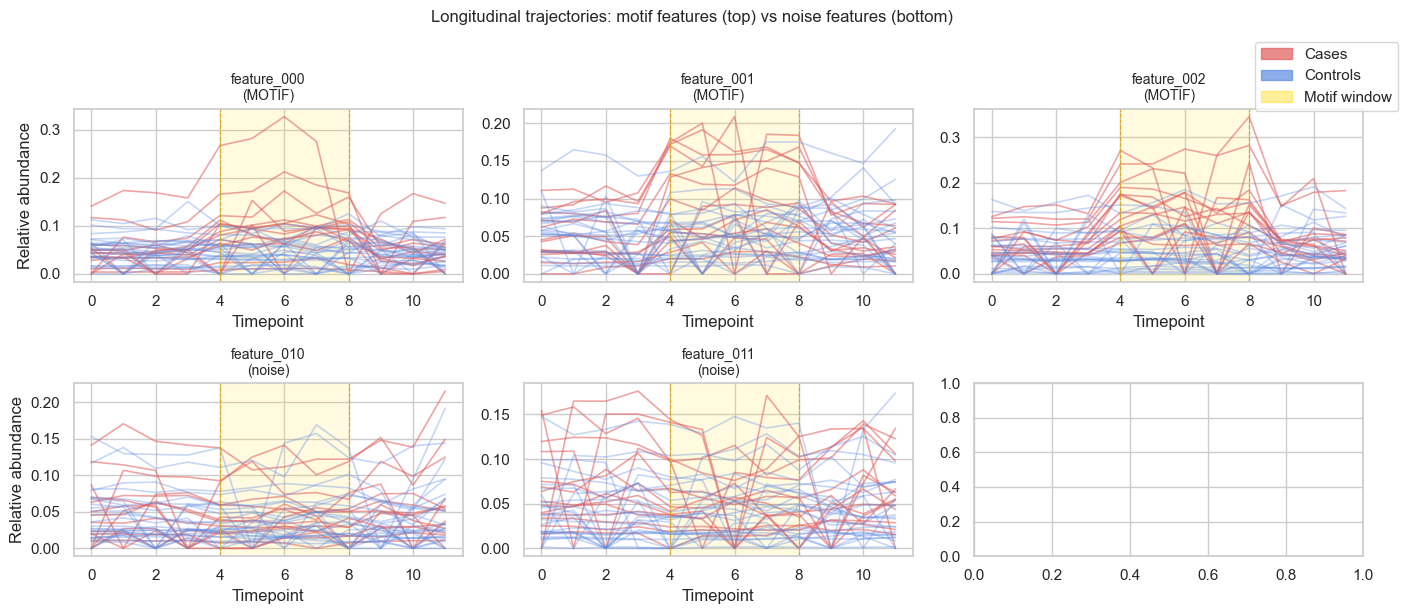

In [4]:
# --- Plot: Trajectories for motif features vs non-motif features ---
motif_feats = truth['motif_features']          # features WITH motif
noise_feats = ['feature_010', 'feature_011']   # features WITHOUT motif
window = truth['motif_window']

fig, axes = plt.subplots(2, len(motif_feats), figsize=(14, 6), sharey=False)

case_color = '#e05c5c'
ctrl_color = '#5c8ae0'

for row_idx, feat_group in enumerate([motif_feats, noise_feats]):
    for col_idx, feat in enumerate(feat_group[:len(motif_feats)]):
        ax = axes[row_idx, col_idx]
        feat_df = df[df['feature'] == feat]

        for subj, grp in feat_df.groupby('subject_id'):
            outcome = grp['outcome'].iloc[0]
            color = case_color if outcome == 1 else ctrl_color
            alpha = 0.55 if outcome == 1 else 0.35
            ax.plot(grp['timepoint'], grp['value'], color=color, alpha=alpha, lw=1.2)

        # Highlight motif window
        ax.axvspan(window[0], window[1], alpha=0.12, color='gold', label='motif window')
        ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
        ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')

        label = f'{feat}\n(MOTIF)' if row_idx == 0 else f'{feat}\n(noise)'
        ax.set_title(label, fontsize=10)
        ax.set_xlabel('Timepoint')
        if col_idx == 0:
            ax.set_ylabel('Relative abundance')

case_patch = mpatches.Patch(color=case_color, label='Cases', alpha=0.7)
ctrl_patch = mpatches.Patch(color=ctrl_color, label='Controls', alpha=0.7)
window_patch = mpatches.Patch(color='gold', label='Motif window', alpha=0.4)
fig.legend(handles=[case_patch, ctrl_patch, window_patch], loc='upper right', bbox_to_anchor=(1.01, 0.98))
fig.suptitle('Longitudinal trajectories: motif features (top) vs noise features (bottom)', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

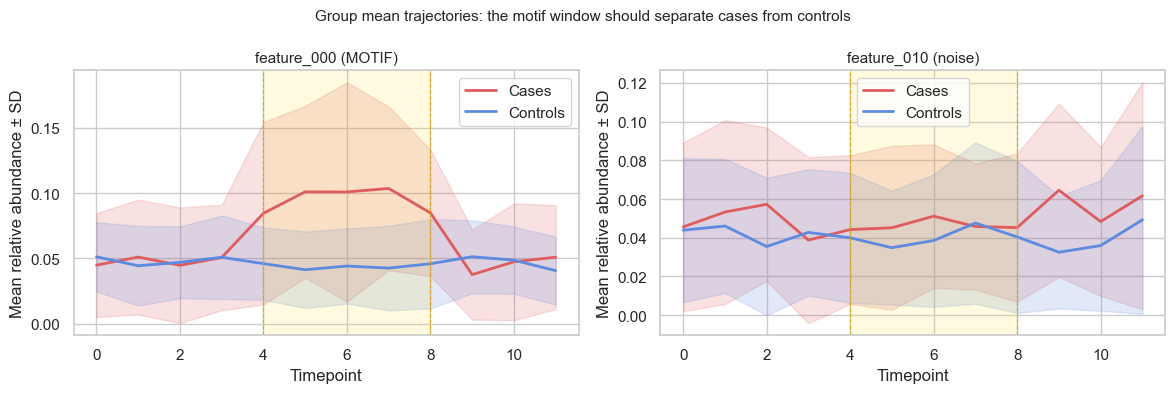

In [5]:
# --- Plot: Mean trajectory ± SD band for motif vs noise features ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat, title in zip(
    axes,
    ['feature_000', 'feature_010'],
    ['feature_000 (MOTIF)', 'feature_010 (noise)']
):
    feat_df = df[df['feature'] == feat]

    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means = grp.mean()
        stds = grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)

    ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
    ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
    ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Mean relative abundance ± SD')
    ax.legend()

fig.suptitle('Group mean trajectories: the motif window should separate cases from controls', fontsize=11)
plt.tight_layout()
plt.show()

---
## 2  `simulate` — Continuous Data (step / ramp / pulse motifs)

Non-compositional data (flow cytometry, gene expression). Three motif shapes.

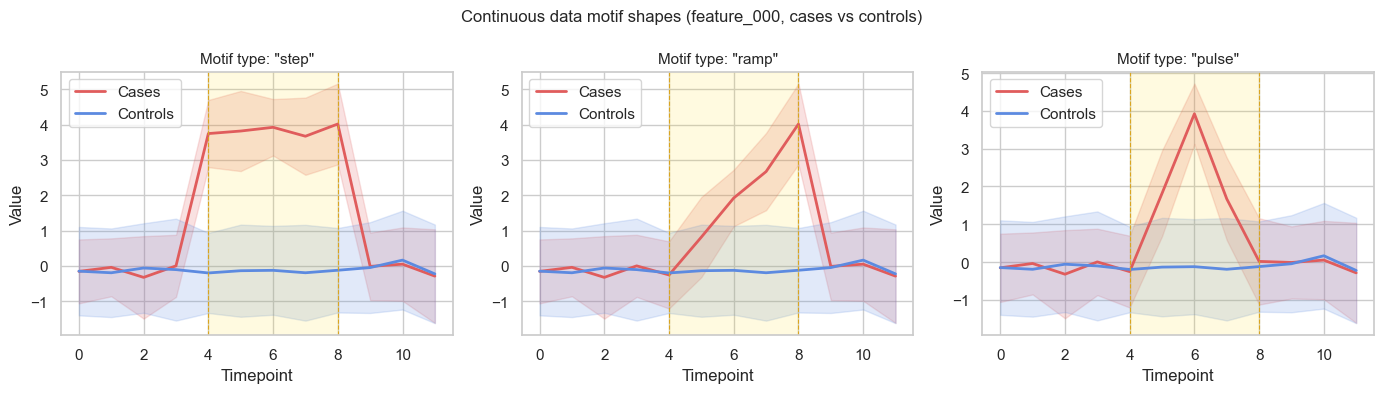

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

for ax, motif_type in zip(axes, ['step', 'ramp', 'pulse']):
    df_c = simulate.simulate_continuous(
        n_subjects=30, n_timepoints=12, n_features=5, n_cases=10,
        motif_features=[0], motif_window=(4, 8),
        motif_type=motif_type, motif_strength=4.0, noise_sd=0.5, seed=0
    )
    feat_df = df_c[df_c['feature'] == 'feature_000']

    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means = grp.mean()
        stds = grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)

    ax.axvspan(4, 8, alpha=0.12, color='gold')
    ax.axvline(4, color='goldenrod', lw=0.8, ls='--')
    ax.axvline(8, color='goldenrod', lw=0.8, ls='--')
    ax.set_title(f'Motif type: "{motif_type}"', fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Value')
    ax.legend()

fig.suptitle('Continuous data motif shapes (feature_000, cases vs controls)', fontsize=12)
plt.tight_layout()
plt.show()

---
## 3  `simulate` — Outcome Types

The simulator supports binary, continuous, and survival outcomes.

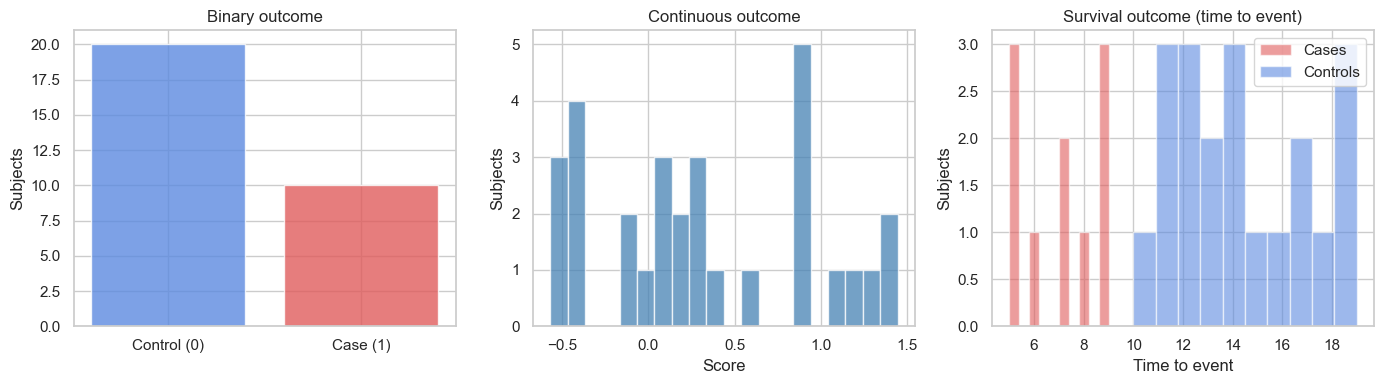

In [7]:
df_binary = simulate.simulate_longitudinal(outcome_type='binary', seed=0)
df_continuous = simulate.simulate_longitudinal(outcome_type='continuous', seed=0)
df_survival = simulate.simulate_longitudinal(outcome_type='survival', seed=0)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Binary
counts = df_binary.drop_duplicates('subject_id')['outcome'].value_counts()
axes[0].bar(['Control (0)', 'Case (1)'], [counts.get(0, 0), counts.get(1, 0)],
            color=[ctrl_color, case_color], alpha=0.8)
axes[0].set_title('Binary outcome')
axes[0].set_ylabel('Subjects')

# Continuous
subjects_c = df_continuous.drop_duplicates('subject_id')
# Use original outcome labels from binary version for coloring
axes[1].hist(subjects_c['outcome'], bins=20, color='steelblue', alpha=0.75)
axes[1].set_title('Continuous outcome')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Subjects')

# Survival
subjects_s = df_survival.drop_duplicates('subject_id')
for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
    grp = subjects_s[subjects_s['outcome'] == outcome]['time_to_event']
    axes[2].hist(grp, bins=10, alpha=0.6, label=label, color=color)
axes[2].set_title('Survival outcome (time to event)')
axes[2].set_xlabel('Time to event')
axes[2].set_ylabel('Subjects')
axes[2].legend()

plt.tight_layout()
plt.show()

---
## 4  `simulate` — evaluation_report

Compares detected features/window against ground truth (used to score harbinger output once implemented).

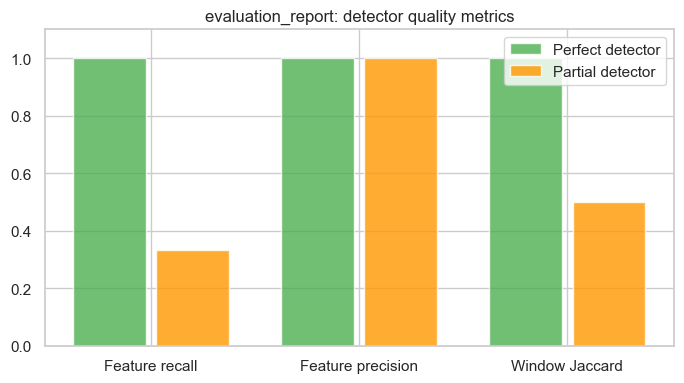

Perfect: {'feature_recall': 1.0, 'feature_precision': 1.0, 'window_jaccard': 1.0, 'true_features': ['feature_001', 'feature_002', 'feature_000'], 'detected_features': ['feature_001', 'feature_002', 'feature_000'], 'true_window': (3, 7), 'detected_window': (3, 7)}
Partial: {'feature_recall': 0.333, 'feature_precision': 1.0, 'window_jaccard': 0.5, 'true_features': ['feature_001', 'feature_002', 'feature_000'], 'detected_features': ['feature_000'], 'true_window': (3, 7), 'detected_window': (5, 8)}


In [8]:
df_eval = simulate.simulate_longitudinal(
    motif_features=[0, 1, 2], motif_window=(3, 7), seed=0
)

# Simulate a 'perfect' detector
perfect = simulate.evaluation_report(
    detected_features=['feature_000', 'feature_001', 'feature_002'],
    detected_window=(3, 7),
    df=df_eval
)

# Simulate a 'partial' detector
partial = simulate.evaluation_report(
    detected_features=['feature_000'],
    detected_window=(5, 8),
    df=df_eval
)

metrics = ['feature_recall', 'feature_precision', 'window_jaccard']
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(metrics))
ax.bar(x - 0.2, [perfect[m] for m in metrics], 0.35, label='Perfect detector', color='#4caf50', alpha=0.8)
ax.bar(x + 0.2, [partial[m] for m in metrics], 0.35, label='Partial detector', color='#ff9800', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(['Feature recall', 'Feature precision', 'Window Jaccard'])
ax.set_ylim(0, 1.1)
ax.set_title('evaluation_report: detector quality metrics')
ax.legend()
plt.tight_layout()
plt.show()

print('Perfect:', perfect)
print('Partial:', partial)

---
## 5  `preprocess` — 🔲 Not yet implemented

Once `tempo/preprocess.py` is filled in, run this section to see the transformed data.

In [9]:
from tempo.preprocess import preprocess, clr_transform, bray_curtis_trajectory

df_raw = simulate.simulate_longitudinal(seed=42)

# --- CLR transform ---
try:
    df_clr = clr_transform(df_raw)
    print('CLR transform output shape:', df_clr.shape)
    df_clr.head()
except NotImplementedError as e:
    print(f'[not yet] {e}')

# --- Bray-Curtis trajectory distances ---
try:
    df_bc = bray_curtis_trajectory(df_raw)
    print('Bray-Curtis trajectory output shape:', df_bc.shape)
    df_bc.head()
except NotImplementedError as e:
    print(f'[not yet] {e}')

CLR transform output shape: (6000, 5)
Bray-Curtis trajectory output shape: (270, 4)


---
## 6  `harbinger` — 🔲 Not yet implemented

Once `tempo/harbinger.py` is filled in, this section will run the full matrix profile motif discovery and display ranked results.

In [10]:
from tempo.harbinger import harbinger

df_h = simulate.simulate_longitudinal(
    n_subjects=40, n_cases=15,
    motif_features=[0, 1, 2], motif_window=(4, 8),
    motif_strength=2.5, seed=42
)

try:
    results = harbinger(df_h, window_size=3, top_k=10)
    print('Harbinger results:')
    print(results)

    # Check how well harbinger recovered the ground truth
    truth = simulate.get_ground_truth(df_h)
    top_features = results['feature'].head(3).tolist()
    top_window = results['motif_window'].iloc[0]
    report = simulate.evaluation_report(top_features, top_window, df_h)
    print('\nEvaluation report:', report)

except NotImplementedError as e:
    print(f'[not yet] {e}')

[not yet] harbinger() is not yet implemented. Planned: STUMPY-based matrix profile computation + permutation enrichment test.


---
## 7  `stats` — 🔲 Not yet implemented

Once `tempo/stats.py` is filled in, this section will run permutation tests and enrichment scoring.

In [11]:
from tempo.stats import permutation_test, enrichment_score, survival_test

df_s = simulate.simulate_longitudinal(motif_features=[0], motif_window=(4, 8), seed=42)

# Permutation test for feature_000 (should be significant)
try:
    perm = permutation_test(df_s, feature='feature_000', motif_window=(4, 8), n_permutations=999)
    print(f"feature_000 permutation test: p = {perm['p_value']:.4f}, observed score = {perm['observed_score']:.4f}")
except NotImplementedError as e:
    print(f'[not yet] {e}')

# Permutation test for feature_010 (should be non-significant)
try:
    perm_null = permutation_test(df_s, feature='feature_010', motif_window=(4, 8), n_permutations=999)
    print(f"feature_010 permutation test: p = {perm_null['p_value']:.4f}, observed score = {perm_null['observed_score']:.4f}")
except NotImplementedError as e:
    print(f'[not yet] {e}')

# Survival test
df_surv = simulate.simulate_longitudinal(outcome_type='survival', motif_features=[0], motif_window=(4, 8), seed=42)
try:
    surv = survival_test(df_surv, feature='feature_000', motif_window=(4, 8))
    print(f"Survival test: p = {surv['p_value']:.4f}")
except NotImplementedError as e:
    print(f'[not yet] {e}')

[not yet] permutation_test() is not yet implemented.
[not yet] permutation_test() is not yet implemented.
[not yet] survival_test() is not yet implemented. Planned: log-rank test via scipy.stats, Cox via lifelines.


---
## 8  `viz` — 🔲 Not yet implemented

Once `tempo/viz.py` is filled in, these cells will use the official plotting API instead of the ad-hoc matplotlib above.

In [12]:
from tempo.viz import plot_motifs, plot_enrichment

df_v = simulate.simulate_longitudinal(
    motif_features=[0, 1, 2], motif_window=(4, 8), motif_strength=2.5, seed=42
)

try:
    fig = plot_motifs(
        df_v,
        features=['feature_000', 'feature_001', 'feature_010'],
        motif_window=(4, 8)
    )
    plt.show()
except NotImplementedError as e:
    print(f'[not yet] {e}')

# plot_enrichment requires harbinger results — wire up once both are ready
try:
    from tempo.harbinger import harbinger
    results = harbinger(df_v, window_size=3, top_k=10)
    fig = plot_enrichment(results, top_k=10)
    plt.show()
except NotImplementedError as e:
    print(f'[not yet] {e}')

[not yet] plot_motifs() is not yet implemented. Planned: matplotlib/seaborn trajectory overlay with motif window shading.
[not yet] harbinger() is not yet implemented. Planned: STUMPY-based matrix profile computation + permutation enrichment test.
